In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [3]:
data = pd.read_csv('household_power_consumption (1).txt', sep=';',
                   parse_dates={'Datetime': ['Date', 'Time']},
                   infer_datetime_format=True,
                   na_values=['?'],
                   low_memory=False,on_bad_lines='skip')


<ipython-input-3-70049ebbecf0>:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  data = pd.read_csv('household_power_consumption (1).txt', sep=';',
<ipython-input-3-70049ebbecf0>:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data = pd.read_csv('household_power_consumption (1).txt', sep=';',


In [4]:
data.head()

Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0

In [5]:
# Set the datetime column as the index
data.set_index('Datetime', inplace=True)


In [6]:
data.isnull().sum()

Global_active_power      4
Global_reactive_power    4
Voltage                  4
Global_intensity         4
Sub_metering_1           4
Sub_metering_2           5
Sub_metering_3           5
dtype: int64

In [7]:
# Handle missing values (e.g., fill with mean or median)
# Convert relevant columns to numeric type, handling errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage',
            'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    try:
        data[col] = pd.to_numeric(data[col], errors='coerce')
    except ValueError as e:
        print(f"Error converting column {col}: {e}")

# Now fill missing values with median for numeric columns
data.fillna(data.median(), inplace=True)


In [8]:
data.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

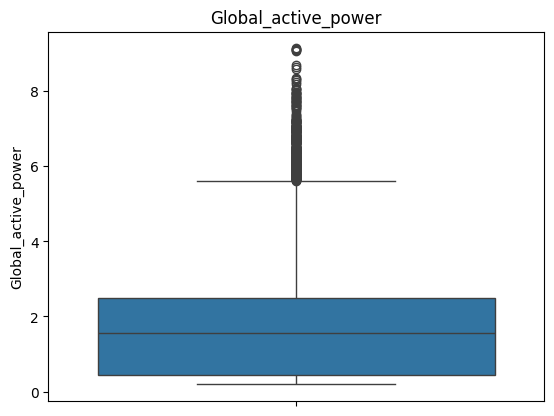

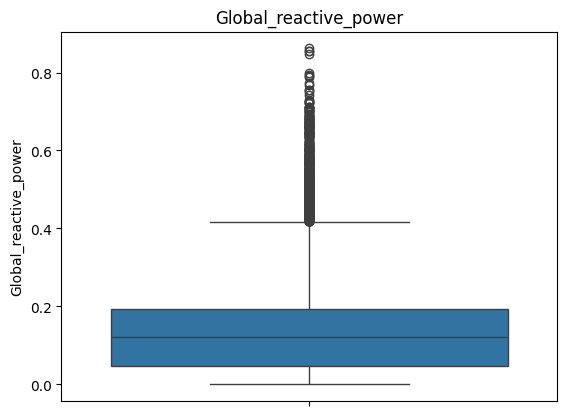

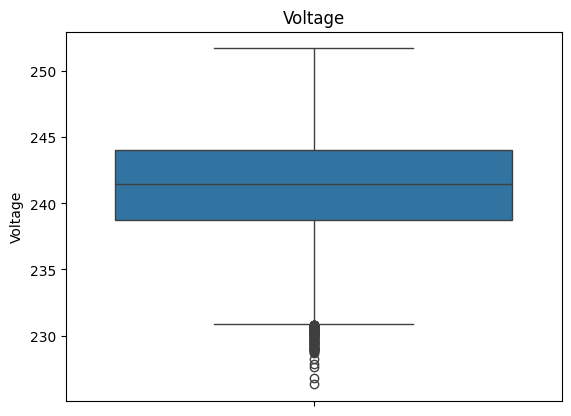

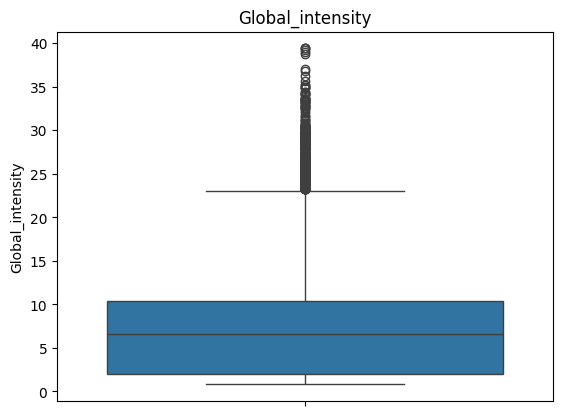

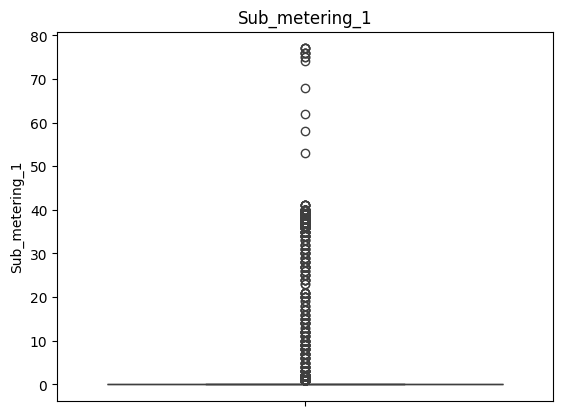

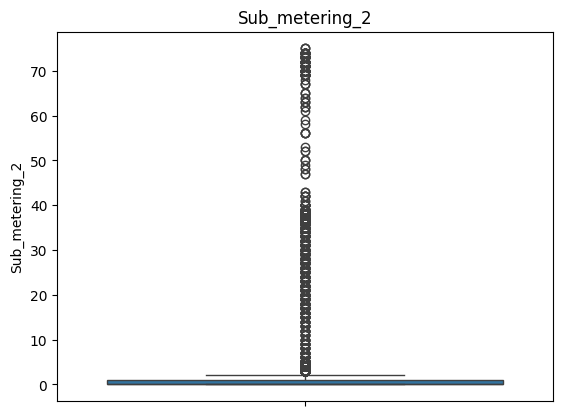

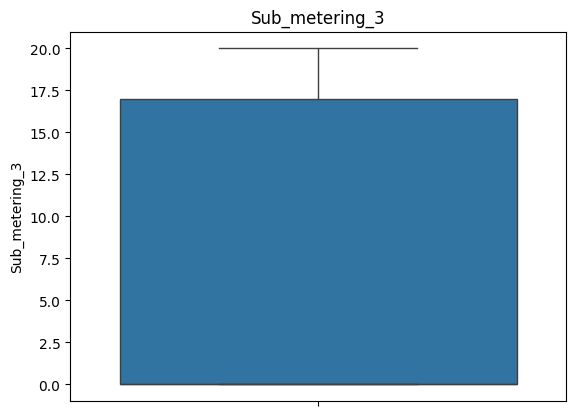

In [9]:
for column in data.columns:
    sns.boxplot(data[column])
    plt.title(column)
    plt.show()


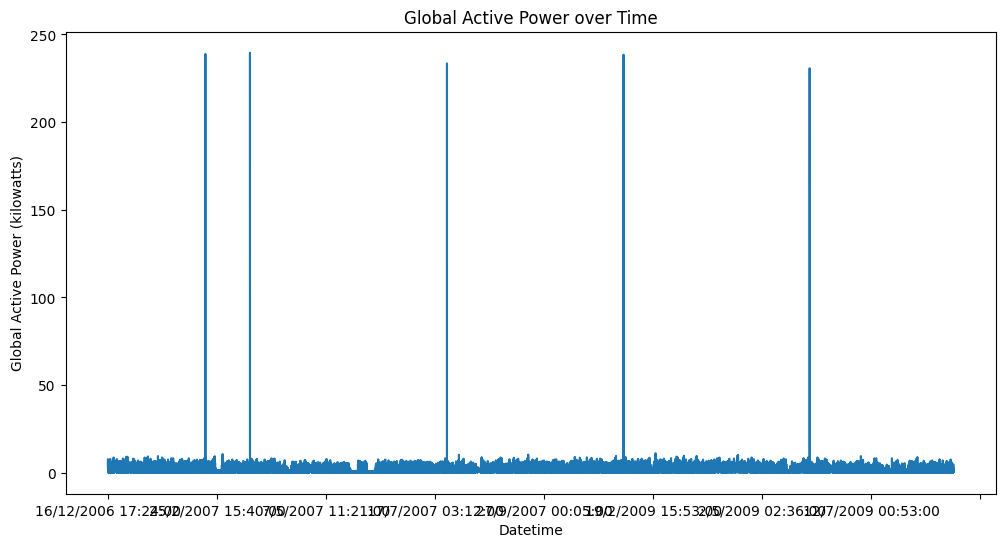

In [ ]:
data['Global_active_power'].plot(figsize=(12, 6))
plt.title('Global Active Power over Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.xlabel('Datetime')
plt.show()


# Corelation matrix

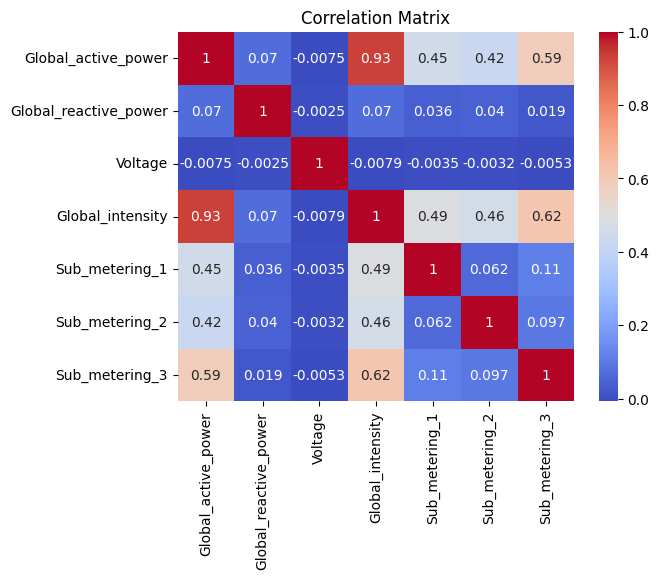

In [ ]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


# ARIMA model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


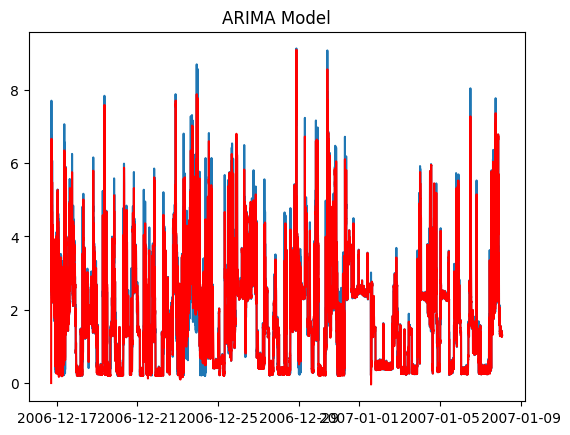

In [10]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(data['Global_active_power'], order=(5, 1, 0))
model_fit = model.fit()
plt.plot(data['Global_active_power'])
plt.plot(model_fit.fittedvalues, color='red')
plt.title('ARIMA Model')
plt.show()


# SARIMA Model

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency T will be used.
  self._init_dates(dates, freq)


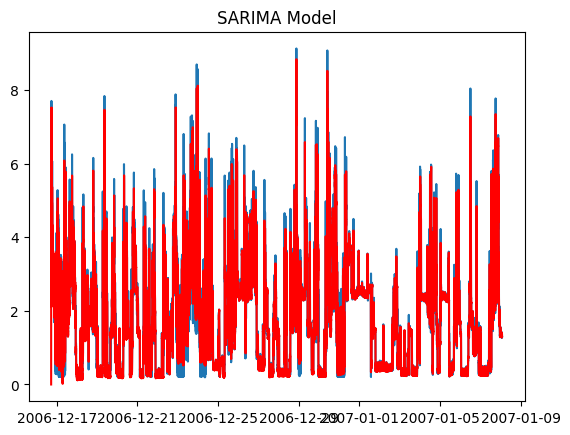

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(data['Global_active_power'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit(disp=False)
plt.plot(data['Global_active_power'])
plt.plot(model_fit.fittedvalues, color='red')
plt.title('SARIMA Model')
plt.show()


# LSTM

202/202 [==============================] - 1s 3ms/step


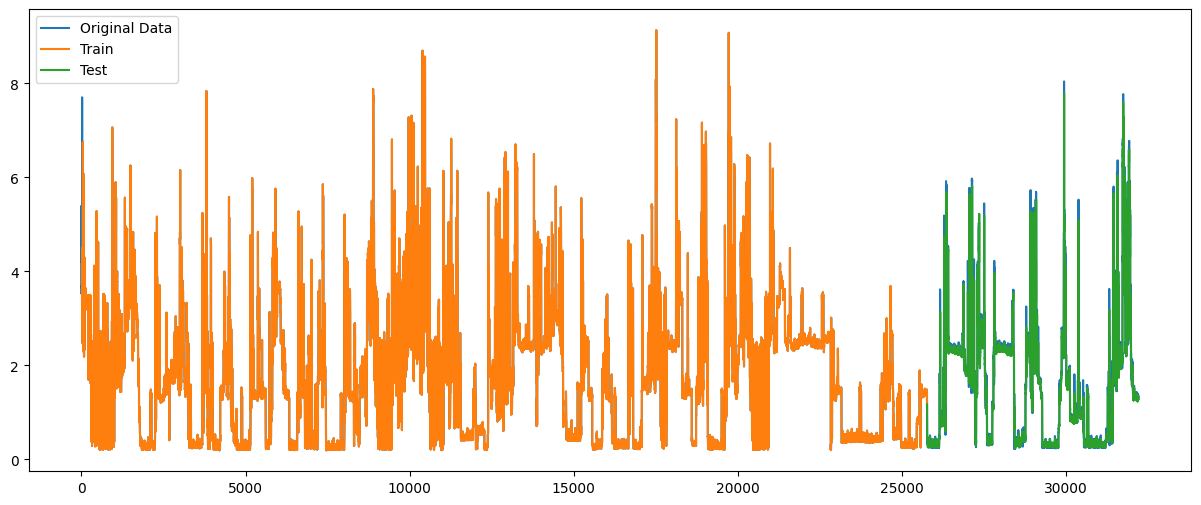

In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Global_active_power'].values.reshape(-1, 1))

# Prepare the data for LSTM
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 24
X, Y = create_dataset(scaled_data, look_back)
X_train, X_test = X[:int(len(X) * 0.8)], X[int(len(X) * 0.8):]
Y_train, Y_test = Y[:int(len(Y) * 0.8)], Y[int(len(Y) * 0.8):]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and fit the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, Y_train, batch_size=1, epochs=1)

# Predict and inverse transform the scaled values
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Plot the results
train_plot = np.empty_like(scaled_data)
train_plot[:, :] = np.nan
train_plot[look_back:len(X_train) + look_back, :] = scaler.inverse_transform(Y_train.reshape(-1, 1))

test_plot = np.empty_like(scaled_data)
test_plot[:, :] = np.nan
# Correct the slice indices to match the size of 'predictions'
test_plot[len(X_train) + look_back:len(X_train) + look_back + len(predictions), :] = predictions

plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Original Data')
plt.plot(train_plot, label='Train')
plt.plot(test_plot, label='Test')
plt.legend()
plt.show()

In [26]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


In [28]:
from sklearn.metrics import mean_squared_error

# Slice train_predict to match the length of train['Global_active_power']
train_predict_sliced = train_predict[:len(train)]
test_predict = model_fit.predict(start=len(train), end=len(data)-1, dynamic=False)

train_score = np.sqrt(mean_squared_error(train['Global_active_power'], train_predict_sliced)) # Use the sliced predictions
test_score = np.sqrt(mean_squared_error(test['Global_active_power'], test_predict))

print(f'Train Score: {train_score:.2f} RMSE')
print(f'Test Score: {test_score:.2f} RMSE')

Train Score: 0.46 RMSE
Test Score: 0.29 RMSE


 # Future Consumption Prediction

In [29]:
forecast = model_fit.forecast(steps=30)[0]


In [49]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure data lengths match
data_length = len(data['Global_active_power'])
train_predict_length = len(train_predict)
test_predict_length = len(test_predict)

# Debugging: Print array shapes
print("Shapes: data_length =", data_length, "train_predict_length =", train_predict_length, "test_predict_length =", test_predict_length)

# Prepare the prediction arrays
train_predict_plot = np.empty(data_length)
train_predict_plot[:] = np.nan

# Adjust the slicing to accommodate the time_step
time_step = 10  # Assuming time_step is 10 based on the error
train_predict_plot[time_step:train_predict_length + time_step] = train_predict[:train_predict_length] # Extend the slice to include the last 'time_step' predictions

# Slice train_predict to match
test_predict_plot = np.empty(data_length)
test_predict_plot[:] = np.nan

# Calculate the correct start index for the test predictions
start_index = train_predict_length + time_step

# Assign test predictions to the correct slice of test_predict_plot
test_predict_plot[start_index: start_index + test_predict_length] = test_predict

# Plot the actual data and predictions
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Global_active_power'], label='Actual Data', color='blue')
plt.plot(data.index, train_predict_plot, label='Train Predict', color='red')
plt.plot(data.index, test_predict_plot, label='Test Predict', color='green')
plt.title('LSTM Model - Global Active Power Prediction')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()
plt.show()

Shapes: data_length = 32193 train_predict_length = 32193 test_predict_length = 6439


ValueError: could not broadcast input array from shape (32193,) into shape (32183,)

In [39]:
data_daily = data['Global_active_power'].resample('D').mean()